import pandas as pd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 -4*x +5
x = 3
y = f(x)
y

20

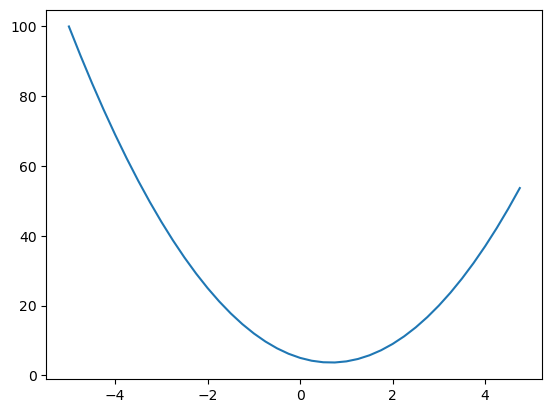

In [5]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs , ys)

In [128]:
a = 2
b = 3
c = 1
d = a*b +c
e = a*b - c
h = 0.1

f = ((c+h) - c)/h

print(f)

import math

1.0000000000000009


In [134]:

a = Value(2 , label = 'a')
b = Value(-3.0,label = 'b')
c = Value(10  , label = 'c')
e = a+b ; e.label = 'e'
d = e +c ; d.label = 'd'
f = Value(-2 , label = 'f')

l = d*f;l.label = 'l'

In [126]:
print(a._prev)
print(b._prev)
print(c._prev)
print(d._prev)
d._op

set()
set()
set()
{Value(data = 10), Value(data = -1.0)}


'+'

In [105]:
import networkx as nx
import matplotlib.pyplot as plt

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_graph(root):
    G = nx.DiGraph()
    
    nodes, edges = trace(root)
    
    node_labels = {}
    
    for n in nodes:
        uid = str(id(n))
        G.add_node(uid)
        node_labels[uid] = f"{n.label} | {n.data} | {n.grad}"
        
        if n._op:
            op_id = uid + n._op
            G.add_node(op_id, shape="square")
            node_labels[op_id] = n._op
            G.add_edge(op_id, uid)
    
    for n1, n2 in edges:
        G.add_edge(str(id(n1)), str(id(n2)) + n2._op)
    
    pos = nx.spring_layout(G)  # You can use other layouts like 'dot' from pygraphviz if installed
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=3000, node_color="lightblue", edge_color="gray")
    plt.show()


In [236]:
class Value:
    def __init__(self,data , _children = (), _op = '' , label = ''):
        
        self.grad=0.0
        self._backward = lambda:None
        self.data = data
        self._prev = set(_children)
        self._op = _op
        
        self.label = label 
        
        
    def __repr__(self):
        return f"Value(data = {self.data} | label = {self.label})"
    
    
    def __add__(self , other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data + other.data , (self , other) , '+')
        
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward = _backward
        
        return out
    
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self , other):
        return self + (-other)
    
    
    
    def __mul__(self , other):
        other = other if isinstance(other , Value) else Value(other)
        
        out = Value(self.data * other.data , (self , other) , '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self*other
    
    
    
    def __pow__(self , other):
        assert isinstance(other , (int , float)) , "only supporting int/float powers for now"
        out = Value(self.data**other , (self ,), f"**{other}")
                    
        def _backward():
            self.grad = other.data * (self.data ** (other.data - 1)) * out.grad 
        
        out._backward()
        
        return out
        
    
    def __truediv__(self , other):
        return self * other**-1
    
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1) /(math.exp(2*n) + 1)
        out = Value(t ,(self , ) ,'tanh')
        
        def _backward():
            self.grad += (1-t**2)*out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        
        x = self.data
        out = Value(math.exp(x) , (self,) ,'exp')
        
        def _backward():
            self.grad = out.data*out.grad
        out._backward()
        
        return out
    def backward(self):
        

        topo = []

        visited = set()

        def build_topo(v):

            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0

            
        for node in reversed(topo):
            node._backward()
        

In [237]:
x1 = Value(2.0 , label = 'x1')
x2 = Value(0.0 , label = 'x2')

w1 = Value(-3.0 , label = 'w1')
w2 = Value(1.0 , label = 'w2')

b = Value(6.8813 , label = 'b')

x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = ' x1w1 + x2w2'

n = x1w1x2w2 + b ; n.label = 'n'

# o = n.tanh();o.label = 'o'

e = (2*n).exp()

o = (e + 1) / (e - 1)



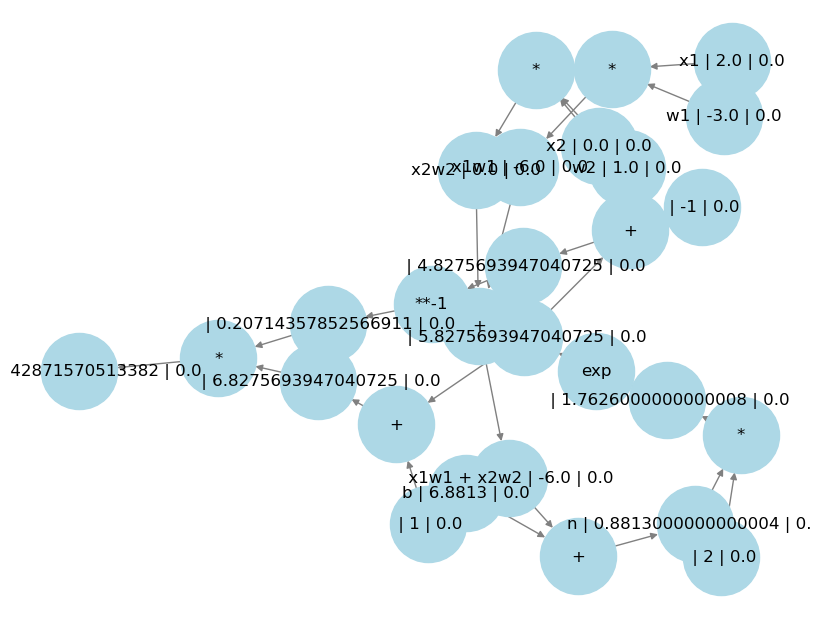

In [238]:
draw_graph(o)

In [220]:
o.backward()

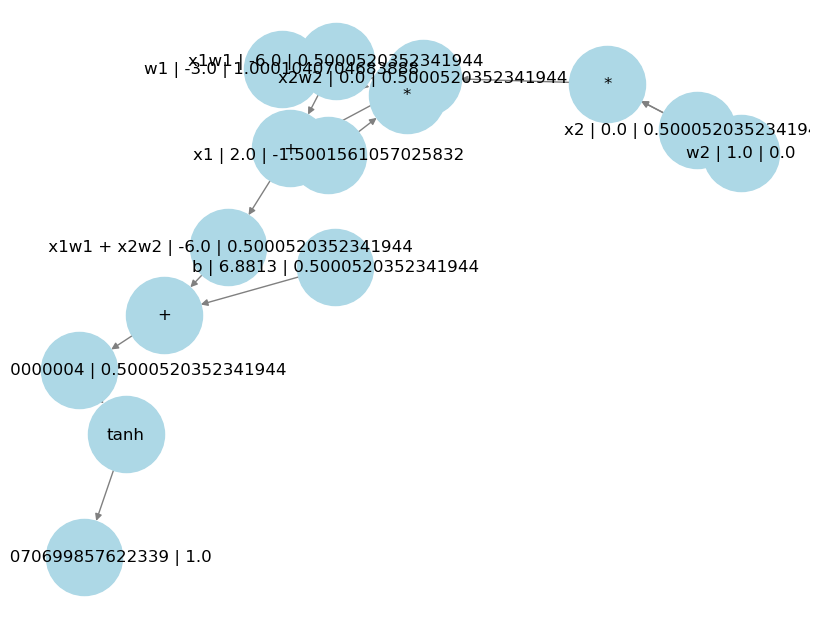

In [221]:
draw_graph(o)

In [258]:
import random

class Neuron :
    def __init__(self, nin):
        
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self , x):
        
        act = sum((wi*xi for wi , xi in zip(self.w , x)) , self.b)
        out = act.tanh()
        print(f"neuron output {out}")
        return out

class Layer:
    def __init__(self , nin , nout):
        print(f"layer shape : {nin,nout}")
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self , x):
        outs = [n(x) for n in self.neurons]
        print(f"\n Layer output : {outs}")
        return outs[0] if len(outs) == 1 else outs
    
    
class MLP:
    
    def __init__(self, nin, nout):
        sz = [nin] + nout
        print(f"mlp sz = {sz}")
        
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nout))]
        
    def __call__(self , x):
        
        for layer in self.layers:
            x = layer(x)
        print(f"\n MLP output {x}")
        return x

In [259]:
# n1 = Neuron(4)
x = [1 ,2,3,]

mlp = MLP( 3 , [4,4,1])
mlp(x)


mlp sz = [3, 4, 4, 1]
layer shape : (3, 4)
layer shape : (4, 4)
layer shape : (4, 1)
neuron output Value(data = 0.6234302957609771 | label = )
neuron output Value(data = 0.9498221491469336 | label = )
neuron output Value(data = 0.9940938010136897 | label = )
neuron output Value(data = -0.9209922672245162 | label = )

 Layer output : [Value(data = 0.6234302957609771 | label = ), Value(data = 0.9498221491469336 | label = ), Value(data = 0.9940938010136897 | label = ), Value(data = -0.9209922672245162 | label = )]
neuron output Value(data = 0.5594195237095206 | label = )
neuron output Value(data = 0.25996502069112326 | label = )
neuron output Value(data = 0.23156513066957093 | label = )
neuron output Value(data = 0.45120914404564283 | label = )

 Layer output : [Value(data = 0.5594195237095206 | label = ), Value(data = 0.25996502069112326 | label = ), Value(data = 0.23156513066957093 | label = ), Value(data = 0.45120914404564283 | label = )]
neuron output Value(data = -0.4370596734447403 

Value(data = -0.4370596734447403 | label = )